In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime
from tabulate import tabulate


def to_scalar(x):
    if isinstance(x, pd.Series) and len(x) == 1:
        return x.iloc[0]
    if hasattr(x, 'item'):
        return x.item()
    return x


etf_list = ['SPY', 'QQQ', 'VTI', 'EFA', 'IEMG', 'TLT', 'HYG', 'XLF', 'XLK', 'XLE']


start_cum = '2015-01-01'
start_ytd = '2024-07-28'
end_date = datetime.today().strftime('%Y-%m-%d')


def first_price_on_or_after(series, ref_date):
    ref_date = pd.to_datetime(ref_date)
    subset = series.loc[series.index >= ref_date]
    return subset.iloc[0] if not subset.empty else None


spy_data = yf.download('SPY', start=start_ytd, end=end_date, progress=False, auto_adjust=True)
spy_returns = spy_data['Close'].pct_change().dropna()

etf_data = []

for etf in etf_list:
    data = yf.download(etf, start=start_cum, end=end_date, progress=False, auto_adjust=True)

    if data.empty:
        print(f"No data for {etf}")
        continue

    p_2015 = first_price_on_or_after(data['Close'], start_cum)
    p_ytd = first_price_on_or_after(data['Close'], start_ytd)
    p_now = data['Close'].iloc[-1]

    if p_2015 is None or p_ytd is None:
        print(f"Skipping {etf}: missing historical price(s)")
        continue

   
    p_2015_val = to_scalar(p_2015)
    p_ytd_val = to_scalar(p_ytd)
    p_now_val = to_scalar(p_now)

    cum_return = round((float(p_now_val) / float(p_2015_val) - 1) * 100, 2)
    ytd_return = round((float(p_now_val) / float(p_ytd_val) - 1) * 100, 2)

  
    avg_volume = int(data['Volume'].mean().item())
    price_range = round(float((data['High'].max() - data['Low'].min()).item()), 2)
    current_price = round(float(p_now_val), 2)

  
    nav_proxy_data = data.loc[start_ytd:]
    nav_spread = (abs(nav_proxy_data['Close'] - nav_proxy_data['Open']) / nav_proxy_data['Close']).mean()
    nav_spread_val = to_scalar(nav_spread)
    nav_spread = round(float(nav_spread_val) * 100, 3)

    etf_data.append([
        etf,
        current_price,
        avg_volume,
        ytd_return,
        cum_return,
        price_range,
        nav_spread
    ])


df = pd.DataFrame(etf_data, columns=[
    'ETF', 'Current Price', 'Avg Volume',
    'YTD Return (%)', 'Cumulative Return (%)',
    'Price Range (2015+)', 'NAV Spread Proxy (%)'
])


print("\nETF Screener Summary (YTD: Jul 28, 2024 → Today)\n")
print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))



ETF Screener Summary (YTD: Jul 28, 2024 → Today)

+-------+-----------------+--------------+------------------+-------------------------+-----------------------+------------------------+
| ETF   |   Current Price |   Avg Volume |   YTD Return (%) |   Cumulative Return (%) |   Price Range (2015+) |   NAV Spread Proxy (%) |
|-------+-----------------+--------------+------------------+-------------------------+-----------------------+------------------------|
| SPY   |          632.08 |     86453814 |            17.47 |                  268.41 |                486.09 |                  0.635 |
| QQQ   |          565.01 |     41553566 |            22.48 |                  494.64 |                496.05 |                  0.831 |
| VTI   |          310.89 |      3338495 |            16.76 |                  250.94 |                236.72 |                  0.646 |
| EFA   |           87.52 |     22309085 |            14.15 |                   96.35 |                 53.12 |                

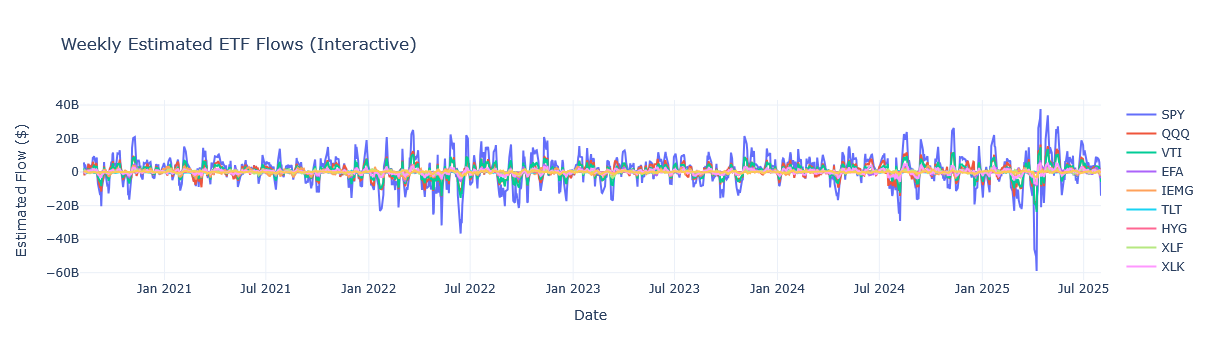

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime

etf_list = ['SPY', 'QQQ', 'VTI', 'EFA', 'IEMG', 'TLT', 'HYG', 'XLF', 'XLK', 'XLE']

all_data = {}
for etf in etf_list:
    ticker = yf.Ticker(etf)
    df_price = ticker.history(period="5y")[['Close']]
    try:
        df_price['Shares'] = ticker.info.get('sharesOutstanding', np.nan)
    except:
        df_price['Shares'] = np.nan
    all_data[etf] = df_price.dropna()

flows = {}
for etf, df in all_data.items():
    df['AUM'] = df['Close'] * df['Shares']
    df['Flow'] = df['AUM'].diff()
    df['Flow_Weekly'] = df['Flow'].rolling(window=5).sum()
    df['Flow_Monthly'] = df['Flow'].rolling(window=21).sum()
    flows[etf] = df[['Flow', 'Flow_Weekly', 'Flow_Monthly']]

combined = pd.concat(flows, axis=1)

 
fig = go.Figure()

for etf in etf_list:
    fig.add_trace(go.Scatter(
        x=combined.index,
        y=combined[etf]['Flow_Weekly'],
        mode='lines',
        name=etf,
        hovertemplate=f"<b>{etf}</b><br>Date: %{{x}}<br>Weekly Flow: %{{y:$,.0f}}<extra></extra>"
    ))

fig.update_layout(
    title="Weekly Estimated ETF Flows (Interactive)",
    xaxis_title="Date",
    yaxis_title="Estimated Flow ($)",
    template="plotly_white",
    hovermode="x unified"
)

fig.show()


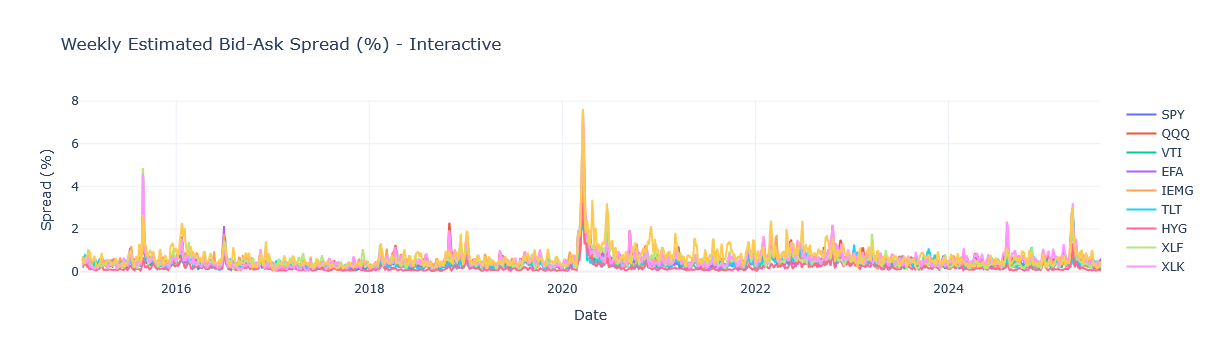


Average Bid‑Ask Spread by Volatility Regime:
 ETF  Low Vol Spread (%)  High Vol Spread (%)
 SPY               0.300                0.646
 QQQ               0.419                0.772
 VTI               0.303                0.641
 EFA               0.339                0.577
IEMG               0.392                0.675
 TLT               0.365                0.432
 HYG               0.154                0.259
 XLF               0.410                0.781
 XLK               0.442                0.839
 XLE               0.564                0.971


In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.graph_objects as go
from datetime import datetime
from bidask import edge_rolling  

def flatten_if_needed(series):
    if isinstance(series, pd.Series):
        return series
    elif isinstance(series, pd.DataFrame) and series.shape[1] == 1:
        return series.iloc[:, 0]
    elif isinstance(series, np.ndarray):
        if series.ndim == 1:
            return pd.Series(series)
        elif series.ndim == 2 and series.shape[1] == 1:
            return pd.Series(series[:, 0])
        else:
            raise ValueError("Spread is a numpy array but not 1D or single-column 2D")
    else:
        raise ValueError(f"Spread is of unexpected type: {type(series)}")

etf_list = ['SPY', 'QQQ', 'VTI', 'EFA', 'IEMG', 'TLT', 'HYG', 'XLF', 'XLK', 'XLE'] 
start = '2015-01-01'
end = datetime.today().strftime('%Y-%m-%d')

vix = yf.download('^VIX', start=start, end=end, progress=False, auto_adjust=True)

if isinstance(vix.index, pd.MultiIndex):
    vix.index = vix.index.get_level_values(1)
vix.index = pd.to_datetime(vix.index)

vix_vol = vix['Close'].pct_change().rolling(5).std()
if isinstance(vix_vol, pd.DataFrame):
    vix_vol = vix_vol.iloc[:, 0]
vix_vol.name = 'VIX Volatility'

spread_data = {}
summary_stats = []

for etf in etf_list:
    print(f"Downloading {etf}...")
    df = yf.download(etf, start=start, end=end, progress=False, auto_adjust=True)
    if df.empty:
        print(f"No data for {etf}")
        continue

    spread_series = edge_rolling(df[['Open', 'High', 'Low', 'Close']], 5)
    spread_series = flatten_if_needed(spread_series)

    df['Spread'] = spread_series
    df['Spread (%)'] = df['Spread'] * 100.0

    vix_vol_aligned = vix_vol.reindex(df.index).ffill()
    if isinstance(vix_vol_aligned, pd.DataFrame):
        vix_vol_aligned = vix_vol_aligned.iloc[:, 0]

    vol_high_threshold = float(vix_vol_aligned.quantile(0.75))
    vol_low_threshold = float(vix_vol_aligned.quantile(0.25))

    high_mask = (vix_vol_aligned > vol_high_threshold)
    low_mask = (vix_vol_aligned < vol_low_threshold)

    df['Volatility Regime'] = 'Normal'
    df.loc[high_mask, 'Volatility Regime'] = 'High'
    df.loc[low_mask, 'Volatility Regime'] = 'Low'

    spread_data[etf] = df[['Spread (%)', 'Volatility Regime']]

    avg_low = df[df['Volatility Regime'] == 'Low']['Spread (%)'].mean() or 0
    avg_high = df[df['Volatility Regime'] == 'High']['Spread (%)'].mean() or 0
    summary_stats.append([etf, round(avg_low, 3), round(avg_high, 3)])


if spread_data:
    combined = pd.concat({etf: d['Spread (%)'] for etf, d in spread_data.items()}, axis=1)
    weekly = combined.rolling(window=5).mean()

    fig = go.Figure()
    for etf in spread_data:
        fig.add_trace(go.Scatter(
            x=weekly.index,
            y=weekly[etf],
            mode='lines',
            name=etf,
            hovertemplate=f"<b>{etf}</b><br>Date: %{{x}}<br>Weekly Spread: %{{y:.3f}}%<extra></extra>"
        ))

    fig.update_layout(
        title="Weekly Estimated Bid‑Ask Spread (%) - Interactive",
        xaxis_title="Date",
        yaxis_title="Spread (%)",
        template="plotly_white",
        hovermode="x unified"
    )

    fig.show()

print("\nAverage Bid‑Ask Spread by Volatility Regime:")
summary_df = pd.DataFrame(summary_stats, columns=['ETF', 'Low Vol Spread (%)', 'High Vol Spread (%)'])
print(summary_df.to_string(index=False))


C:\Users\herri\AppData\Local\Temp\ipykernel_40448\3416470527.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True



 Using columns: ['EFA', 'HYG', 'IEMG', 'QQQ', 'SPY', 'TLT', 'VTI', 'XLE', 'XLF', 'XLK']

=== ETF Risk Dashboard ===
 ETF  Annual Return %  Annual Volatility %  Sharpe Ratio
 EFA         7.922153            17.420420      0.339955
 HYG         4.575748             8.445457      0.304986
IEMG         7.122223            20.134592      0.254399
 QQQ        19.368029            22.192418      0.782611
 SPY        13.985387            17.998509      0.665910
 TLT         0.130652            15.229550     -0.122745
 VTI        13.584848            18.325488      0.632171
 XLE         9.304173            29.755380      0.245474
 XLF        13.437432            22.202350      0.515145
 XLK        21.615958            23.886630      0.821211


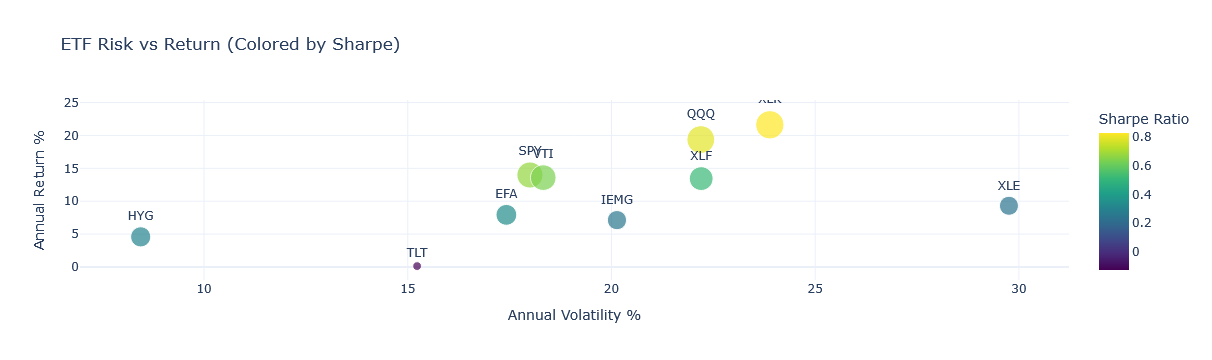

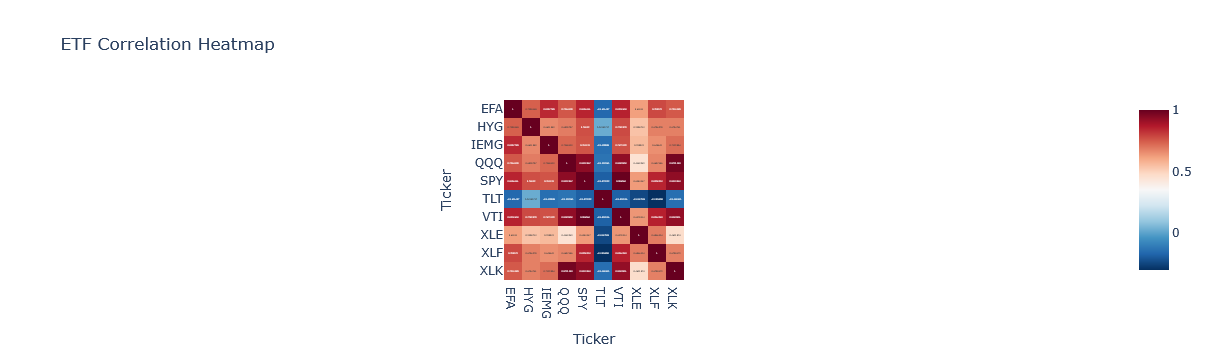

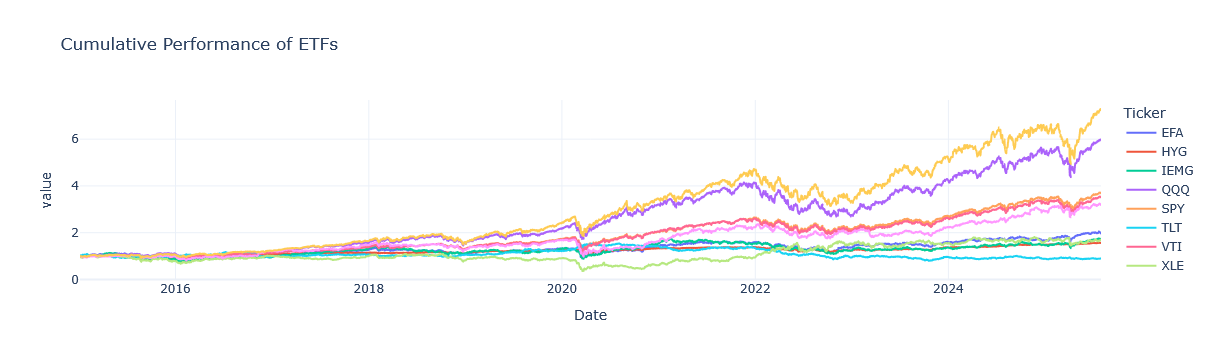


=== Latest 60-Day Rolling Correlation vs SPY ===
Ticker
EFA     0.561962
HYG     0.793384
IEMG    0.563531
QQQ     0.947804
SPY     1.000000
TLT     0.090988
VTI     0.997087
XLE     0.295671
XLF     0.854300
XLK     0.887458
Name: 2025-07-31 00:00:00, dtype: float64


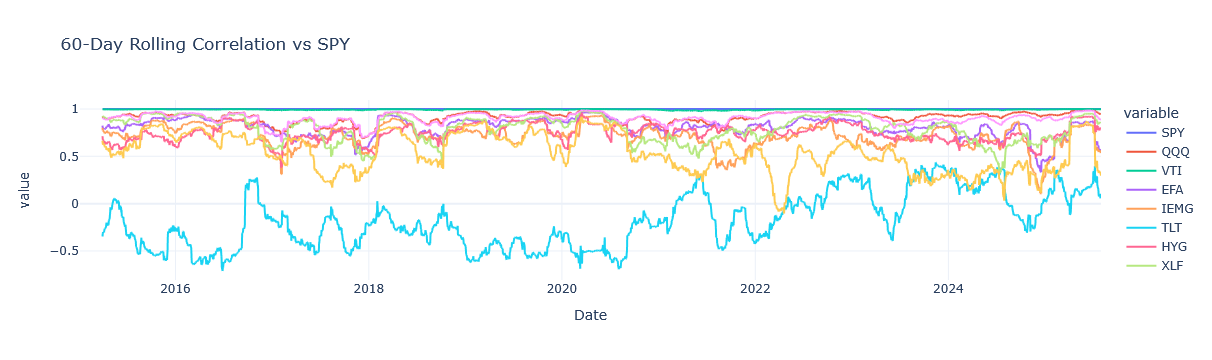

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from datetime import datetime


etf_list = ['SPY', 'QQQ', 'VTI', 'EFA', 'IEMG', 'TLT', 'HYG', 'XLF', 'XLK', 'XLE']


start = '2015-01-01'
end = datetime.today().strftime('%Y-%m-%d')


data = yf.download(etf_list, start=start, end=end, progress=False)


if isinstance(data.columns, pd.MultiIndex):
    if 'Adj Close' in data.columns.get_level_values(0):
        raw_data = data.xs('Adj Close', level=0, axis=1)
    else:
        raw_data = data.xs('Close', level=0, axis=1)
else:
    if 'Adj Close' in data.columns:
        raw_data = data['Adj Close']
    else:
        raw_data = data['Close']

print(f" Using columns: {list(raw_data.columns)}")


returns = raw_data.pct_change().dropna()


corr_matrix = returns.corr()


annual_vol = returns.std() * np.sqrt(252) * 100
annual_ret = returns.mean() * 252 * 100
risk_free_rate = 0.02  # 2%
sharpe_ratio = (returns.mean() * 252 - risk_free_rate) / (returns.std() * np.sqrt(252))


risk_df = pd.DataFrame({
    'ETF': annual_ret.index,
    'Annual Return %': annual_ret.values,
    'Annual Volatility %': annual_vol.values,
    'Sharpe Ratio': sharpe_ratio.values
})

print("\n=== ETF Risk Dashboard ===")
print(risk_df.to_string(index=False))


min_size = 0.1
sizes = risk_df['Sharpe Ratio'] - risk_df['Sharpe Ratio'].min() + min_size


fig_risk = px.scatter(
    risk_df,
    x='Annual Volatility %',
    y='Annual Return %',
    text='ETF',
    color='Sharpe Ratio',
    size=sizes,
    title='ETF Risk vs Return (Colored by Sharpe)',
    color_continuous_scale='Viridis'
)
fig_risk.update_traces(textposition='top center')
fig_risk.update_layout(template="plotly_white")
fig_risk.show()


fig_corr = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    title="ETF Correlation Heatmap"
)
fig_corr.update_layout(template="plotly_white")
fig_corr.show()


cum_returns = (1 + returns).cumprod()
fig_cum = px.line(
    cum_returns,
    title="Cumulative Performance of ETFs"
)
fig_cum.update_layout(template="plotly_white")
fig_cum.show()


benchmark = 'SPY'
rolling_corr = returns.rolling(window=60).corr(returns[benchmark])


latest_corr = rolling_corr.loc[rolling_corr.index[-1]]
print("\n=== Latest 60-Day Rolling Correlation vs SPY ===")
print(latest_corr)


rolling_corr_df = rolling_corr.reset_index()
fig_roll = px.line(
    rolling_corr_df,
    x='Date',
    y=etf_list,
    title='60-Day Rolling Correlation vs SPY'
)
fig_roll.update_layout(template="plotly_white")
fig_roll.show()

